<a href="https://colab.research.google.com/github/hooshmandzade/MAEPS-CPT-prediction-/blob/main/PDS_MAEPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





   
# Download, read and load the raw data



In [44]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import psycopg2
import re
from itertools import cycle

In [23]:
!pip install gdown -q
!gdown --id 13NHW7x3PfT4URc8x0XSK9oZdNoebdrxS --output vw_cpt_brussels_params_completeset_20250318_remapped.parquet
raw = pd.read_parquet('vw_cpt_brussels_params_completeset_20250318_remapped.parquet')

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=13NHW7x3PfT4URc8x0XSK9oZdNoebdrxS
To: /content/vw_cpt_brussels_params_completeset_20250318_remapped.parquet
100% 64.6M/64.6M [00:00<00:00, 66.5MB/s]


In [24]:
raw = raw.drop(['index','sondeernummer','pkey_sondering'], axis=1)

In [25]:
raw.to_csv("cpt.csv", index=False)

# Database


In [26]:
# !pip -q install psycopg2-binary pandas python-dotenv

# ---------- 1) Connection (Supabase pooled port 6543 + SSL) ----------
user     = "postgres.vsqvzufrqjpjyulhetwl"
password = "MAEPSmaeps12345"
host     = "aws-1-eu-central-1.pooler.supabase.com"
port     = 6543
dbname   = "postgres"

def get_conn():
    return psycopg2.connect(
        host=host, port=port, dbname=dbname, user=user, password=password,
        sslmode="require"
    )

TABLE_STAGING = "stg_cpt_raw"

# ---------- 2) Sanitize columns (you already did this) ----------
def sanitize(name: str) -> str:
    s = re.sub(r'\s+', '_', str(name).strip())
    s = re.sub(r'[^0-9a-zA-Z_]', '_', s)
    if s and s[0].isdigit():
        s = '_' + s
    return s.lower()

raw = raw.copy()
orig2san, seen, new_cols = {}, set(), []
for c in raw.columns:
    base = sanitize(c)
    name = base
    i = 1
    while name in seen:
        name = f"{base}_{i}"; i += 1
    seen.add(name)
    orig2san[c] = name
    new_cols.append(name)
raw.columns = new_cols
print("Columns ->", raw.columns.tolist())

# ---------- 3) Create staging table ----------
ddl_cols = ",\n  ".join([f'"{c}" TEXT' for c in raw.columns])
ddl = f'CREATE TABLE IF NOT EXISTS {TABLE_STAGING} (\n  {ddl_cols}\n);'

with get_conn() as conn:
    conn.autocommit = True
    with conn.cursor() as cur:
        cur.execute(ddl)
print("Staging table ready.")


# ---------- 4) Bulk load DataFrame via COPY FROM STDIN ----------
cols_quoted = ", ".join([f'"{c}"' for c in raw.columns])
copy_sql = f"""
COPY {TABLE_STAGING} ({cols_quoted})
FROM STDIN WITH (FORMAT csv, HEADER true, DELIMITER ',', QUOTE '\"', NULL '');
"""

def copy_df(df_chunk: pd.DataFrame):
    buf = io.StringIO()
    df_chunk.to_csv(buf, index=False)  # header included
    buf.seek(0)
    with get_conn() as conn:
        with conn.cursor() as cur:
            cur.copy_expert(copy_sql, buf)
        conn.commit()

copy_df(raw)
print("Loaded DataFrame into staging table.")

# ---------- 5) Verify row count ----------
with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT COUNT(*) FROM {TABLE_STAGING};")
        print("Rows in staging:", cur.fetchone()[0])

TYPED_TABLE = "cpt_brussels_params"
typed_sql = f"""
DROP TABLE IF EXISTS {TYPED_TABLE};
CREATE TABLE {TYPED_TABLE} AS
SELECT
  COALESCE(NULLIF(sondeernummer, ''), NULL)::text               AS sondeernummer,
  NULLIF(x, '')::double precision                               AS x,
  NULLIF(y, '')::double precision                               AS y,
  NULLIF(diepte_mtaw, '')::double precision                     AS diepte_mtaw,
  NULLIF(qc, '')::double precision                               AS qc,
  NULLIF(fs, '')::double precision                               AS fs,
  NULLIF(rf, '')::double precision                               AS rf
  -- TODO: add the rest of your columns with appropriate casts
FROM {TABLE_STAGING};

CREATE INDEX IF NOT EXISTS idx_{TYPED_TABLE}_sondeer ON {TYPED_TABLE}(sondeernummer);
CREATE INDEX IF NOT EXISTS idx_{TYPED_TABLE}_xy ON {TYPED_TABLE}(x, y);
"""


Columns -> ['sondering_id', 'x', 'y', 'start_sondering_mtaw', 'diepte_sondering_tot', 'diepte', 'diepte_mtaw', 'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_id']
Staging table ready.
Loaded DataFrame into staging table.
Rows in staging: 7336266


# Separate labeled and unlabeled data


In [27]:
user     = "postgres.vsqvzufrqjpjyulhetwl"
password = "MAEPSmaeps12345"
host     = "aws-1-eu-central-1.pooler.supabase.com"
port     = 6543
dbname   = "postgres"

def get_conn():
    return psycopg2.connect(
        host=host, port=port, dbname=dbname, user=user, password=password,
        sslmode="require"
    )

query = "SELECT * FROM raw.labelled_cpt"

with get_conn() as conn:
    labeled_data = pd.read_sql(query, conn)

print("Data loaded from raw.labelled_cpt")
display(labeled_data.head())

/tmp/ipython-input-3431142227.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  labeled_data = pd.read_sql(query, conn)


Data loaded from raw.labelled_cpt


,sondering_id,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
0,314,153278.2,181734.6,15.26,25.4,1.6,13.66,1.17,0.035,35.89400438353187,2.991452991452992,3.0583711988815097,2.56434,5.0,1.434e-07,Quartair
1,314,153278.2,181734.6,15.26,25.4,1.7,13.56,1.57,0.033,42.56231931660572,2.1019108280254777,2.1389681099299973,2.406724,5.0,4.321e-07,Quartair
2,314,153278.2,181734.6,15.26,25.4,1.8,13.459999999999999,1.43,0.036,38.53699112706456,2.5174825174825175,2.5692263773908075,2.491219,5.0,2.392e-07,Quartair
3,314,153278.2,181734.6,15.26,25.4,1.9,13.36,0.5,0.024,15.678500768214604,4.8,5.111165775078922,2.982185,3.0,7.7e-09,Quartair
4,314,153278.2,181734.6,15.26,25.4,2.0,13.26,1.33,0.023,33.203118561084175,1.7293233082706767,1.7721100750416183,2.440158,5.0,3.419e-07,Quartair


In [28]:
numeric_cols = ['x',
 'y',
 'start_sondering_mtaw',
 'diepte_sondering_tot',
 'diepte',
 'diepte_mtaw',
 'qc',
 'fs',
 'qtn',
 'rf',
 'fr',
 'icn',
 'sbt',
 'ksbt']
labeled_data[numeric_cols] = labeled_data[numeric_cols].apply(pd.to_numeric)

In [29]:
# Run only if we want to separate layers with two labels with + separator
# Split two layers in one label
labeled_data['lithostrat_id'] = labeled_data['lithostrat_id'].str.split(r'\s*\+\s*')

# Expand each list into multiple rows
labeled_data = labeled_data.explode('lithostrat_id', ignore_index=True)

In [30]:
# Check Missingness
labeled_data.describe(include='all')

,sondering_id,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
count,229712,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229712.000000,229663.000000,229663.000000,2.296630e+05,218822
unique,242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
top,13081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quartair
freq,4502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50114
mean,NaN,150841.633443,174295.718352,60.032023,21.481577,11.115052,48.916971,7.837977,0.171518,89.747659,2.573272,2.750621,2.341620,4.884566,3.624308e-05,NaN
std,NaN,6462.260159,4260.393361,27.086452,7.121785,7.284599,28.162086,7.849809,0.176871,103.895085,3.316960,8.127418,0.424227,0.887044,1.106157e-03,NaN
min,NaN,139799.200000,164730.190000,14.330000,3.660000,0.020000,-13.830000,0.001000,0.000054,0.001000,0.002309,0.001000,0.431061,2.000000,0.000000e+00,NaN
25%,NaN,143925.218000,171171.349000,43.090000,16.560000,5.280000,30.350000,2.462950,0.058000,26.007253,1.451613,1.499422,2.037102,4.000000,6.120000e-08,NaN
50%,NaN,150703.297000,174557.000000,57.180000,20.370000,9.840000,46.160000,5.080000,0.104000,62.793000,2.344686,2.475068,2.311483,5.000000,8.416000e-07,NaN
75%,NaN,157234.890000,177932.350000,72.590000,26.180000,15.780000,64.520000,11.280000,0.232000,114.824230,3.335396,3.566580,2.685982,6.000000,5.743950e-06,NaN


{'whiskers': [<matplotlib.lines.Line2D at 0x7b97021a15b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b97021a2d20>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b97021a3230>],
 'medians': [<matplotlib.lines.Line2D at 0x7b97021a3c80>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b97021a2390>],
 'means': []}

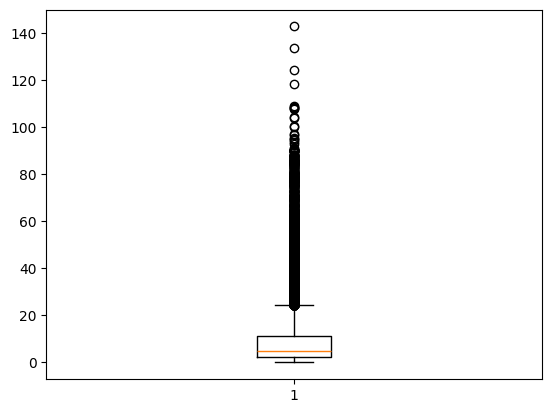

In [31]:
# Check Range
plt.boxplot(labeled_data['qc'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7b9702175bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b9702176d80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b9702176ab0>],
 'medians': [<matplotlib.lines.Line2D at 0x7b9702177cb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b97021762d0>],
 'means': []}

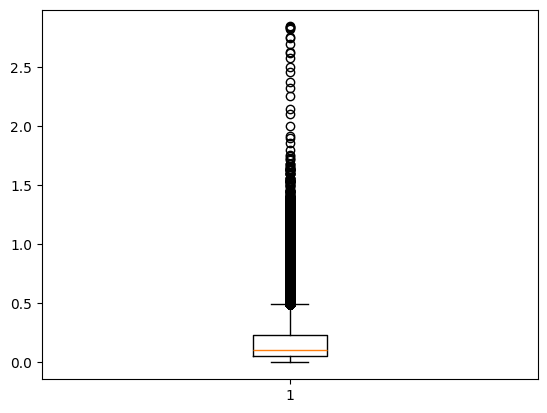

In [32]:
plt.boxplot(labeled_data['fs'])

In [33]:
# Add an ID column for lithostrat_id, only what we gathered from meeting (will add if file is uploaded)
layer_id = {'Aalbeke' : 1670,
'Asse' : 1410,
'Bolderberg' : 1121,
'Brussel' : 1480,
'Diest' : 1120,
'Kwatrecht' : 1540,
'Lede' : 1440,
'Merelbeke' : 1530,
'Mons_en_Pevele' : 1690,
'Mont_Panisel' : 1570,
'Orchies' : 1700,
'Quartair' : 1059,
'Sint_Huibrechts_Hern' : 1350,
'Ursel' : 1400,
'Wemmel' : 1420}

In [34]:
# No ID number layers as -1
labeled_data['lithostrat_num'] = labeled_data['lithostrat_id'].map(layer_id).fillna(-1).astype(int)

In [35]:
impt_layers_only = labeled_data[labeled_data['lithostrat_num'] != -1]

In [36]:
dummies = pd.get_dummies(impt_layers_only['lithostrat_id'])
impt_layers_only = pd.concat([impt_layers_only, dummies], axis=1)

In [37]:
impt_layers_only[['qc','fs', 'rf', 'diepte']].corr()

,qc,fs,rf,diepte
qc,1.000000,0.717849,-0.127249,0.210896
fs,0.717849,1.000000,0.119881,0.351020
rf,-0.127249,0.119881,1.000000,0.059365
diepte,0.210896,0.351020,0.059365,1.000000


In [38]:
impt_layers_only[['qc','fs', 'rf', 'diepte']].skew()

,0
qc,2.511213
fs,2.051881
rf,144.554810
diepte,0.694578


In [39]:
impt_layers_only['log_qc'] = np.log(impt_layers_only['qc'])
impt_layers_only['log_fs'] = np.log(impt_layers_only['fs'])

# Train, Test, Validation Datasets

In [40]:
#excluded_ids = {4629, 3892, 3675, 4455, 4859, 14000, 4449} # Rare layers
#sondering_id = [i for i in labeled_data["sondering_id"].unique() if i not in excluded_ids]
sondering_id = labeled_data["sondering_id"].unique()
train_sondering_id = [i for i in sondering_id[:int(len(sondering_id)*0.9)]]
test_sondering_id = [i for i in sondering_id if i not in train_sondering_id]
impt_layers_only.groupby("lithostrat_id").agg(distinct_sondering_id=('sondering_id', 'nunique'), total_records=('sondering_id', 'count'),id=('sondering_id','max')).sort_values(by='distinct_sondering_id')

,distinct_sondering_id,total_records,id
lithostrat_id,,,
Orchies,1,250,4449
Diest,6,8711,4415
Bolderberg,7,2181,4678
Merelbeke,10,1144,4383
Sint_Huibrechts_Hern,11,7985,4919
Ursel,21,3964,4678
Kwatrecht,24,4337,4647
Asse,29,4906,4916
Aalbeke,41,11465,495


In [41]:
X = impt_layers_only.drop('lithostrat_id', axis=1)
y = impt_layers_only['lithostrat_id']
x_train = X[X['sondering_id'].isin(train_sondering_id)]
x_test = X[X['sondering_id'].isin(test_sondering_id)]
y_train = y[X['sondering_id'].isin(train_sondering_id)]
y_test = y[X['sondering_id'].isin(test_sondering_id)]

print("Train-test split based on sondering_id complete.")
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Train-test split based on sondering_id complete.
Training set shape: (148411, 33)
Test set shape: (45724, 33)


#Visualization

In [45]:
def visualize_cpt(
    df: pd.DataFrame,
    cpt_id,
    depth_col="diepte",
    qc_col="qc",
    fs_col="fs",
    label_col="lithostrat_id",
    cpt_id_col="sondering_id",
    title_prefix="CPT",
    annotate_layers=True,
    alpha=0.25,
    figsize=(6, 8),
):
    """
    Butterfly CPT: qc (left half) and fs (right half) vs depth with shaded layers.
    """

    # --- Select one CPT ---
    cols = [depth_col, qc_col, fs_col, label_col]
    cpt = (
        df.loc[df[cpt_id_col] == cpt_id, cols]
        .dropna(subset=[depth_col])
        .sort_values(depth_col)
        .copy()
    )

    # Check if the DataFrame slice is empty
    if cpt.empty:
        print(f"No data found for CPT ID: {cpt_id}")
        return None, None # Return None for figure and axes

    # --- Build simple layer runs (contiguous same-label intervals) ---
    depths = cpt[depth_col].to_list()
    labels = cpt[label_col].to_list()
    layer_runs = []
    start = 0
    for i in range(1, len(labels)):
        if labels[i] != labels[i - 1]:
            layer_runs.append((labels[start], depths[start], depths[i - 1]))
            start = i
    layer_runs.append((labels[start], depths[start], depths[-1]))

    # --- Figure & axes ---
    fig, ax_qc = plt.subplots(figsize=figsize)
    ax_fs = ax_qc.twiny()  # top x-axis for fs
    ax_fs.xaxis.set_ticks_position("top")
    ax_fs.xaxis.set_label_position("top")

    # Curves: qc from center to left, fs from center to right (but axis runs right->0)
    ax_qc.plot(cpt[qc_col], cpt[depth_col], lw=1.5, color="blue", label=qc_col)
    ax_fs.plot(cpt[fs_col], cpt[depth_col], lw=1.5, color="orange",label=fs_col)

    # Labels
    ax_qc.set_xlabel(qc_col)
    ax_fs.set_xlabel(fs_col)
    ax_qc.set_ylabel("Depth (m)")
    ax_qc.invert_yaxis()
    ax_qc.grid(True, alpha=0.4, linewidth=0.6)

    # --- Layer shading ---
    colors = cycle(plt.rcParams["axes.prop_cycle"].by_key().get("color", ["#7f7f7f"]))
    label_colors = {}
    for lab, z_top, z_bot in layer_runs:
        if lab == "Unlabeled":
            color = "#DDDDDD"
        else:
            if lab not in label_colors:
                label_colors[lab] = next(colors)
            color = label_colors[lab]
        ax_qc.axhspan(z_top, z_bot, color=color, alpha=alpha, lw=0)
        if annotate_layers and lab != "Unlabeled":
            z_mid = 0.5 * (z_top + z_bot)
            ax_qc.text(
                0.5, z_mid, str(lab),     # 0.5 centers horizontally
                va="center", ha="center", # vertical and horizontal centering
                fontsize=9,
                transform=ax_qc.get_yaxis_transform(), # keep text aligned to axes
            )

    ax_qc.set_xlim(0, 60)   # 0 (center) -> left edge
    ax_fs.set_xlim(1.8, 0)   # right edge -> 0 (center)

    # Title & layout
    fig.suptitle(f"{title_prefix} {cpt_id} — {qc_col} (left) & {fs_col} (right)", y=0.98)
    plt.tight_layout()
    return fig, (ax_qc, ax_fs)


Example usage:

(<Figure size 600x800 with 2 Axes>,
 (<Axes: xlabel='qc', ylabel='Depth (m)'>, <Axes: xlabel='fs'>))

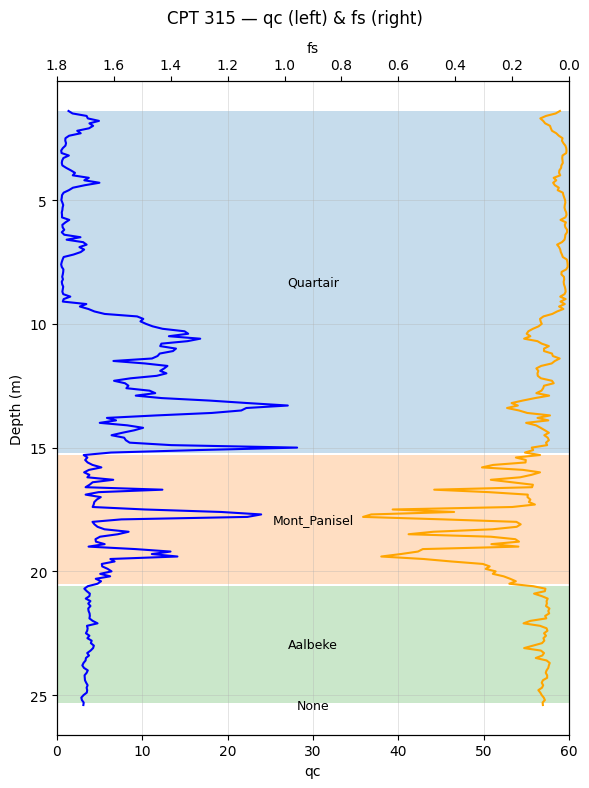

In [46]:
visualize_cpt(labeled_data, "315")